# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque # I also import collections in order to keep a history of the lines.
%matplotlib inline

## Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    width = img.shape[0]
    height = img.shape[1]
    blank =  np.zeros((width,height,3), np.uint8)
    [left_a,left_b,right_a,right_b] = get_line_parameters(lines)
    [left_a,left_b,right_a,right_b] = unshake(history,left_a,left_b,right_a,right_b)
    if not np.isnan(left_a) and not np.isnan(left_b) and not np.isnan(right_a) and not np.isnan(right_b):
        left_y0 = int(width*.6)
        left_x0 = int((left_y0 - left_b)/left_a)
        left_y1 = int(height)
        left_x1 = int((left_y1 - left_b)/left_a)
        right_y0 = int(width*.6)
        right_x0 = int((right_y0 - right_b)/right_a)
        right_y1 = int(height)
        right_x1 = int((right_y1 - right_b)/right_a)
        lane_lines = [[[left_x0,left_y0,left_x1,left_y1    ]],
                 [[right_x0,right_y0,right_x1,right_y1]]]
    for line in lane_lines:
            for x1,y1,x2,y2 in line:
                cv2.line(blank, (x1, y1), (x2, y2), color, thickness)
    output = weighted_img(blank,img)
    return output

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    output = draw_lines(line_img, lines)
    return output, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_line_parameters(lines):
    
    """  I made this function to get a and b parameters from the line equation "y = a*x + b"
         for both left and right lanes.
         I separated the lines respectively to their slope, all slopes greater than .3 corresponds to the right line of the lane 
         while the negative lines less than -.3 corresponds to the left line of the lane.
         Finally I retrieve the a and b parameters using the median instead of the average because is more robust
         facing disturbances.
    """
    left_a = []
    left_b = []
    right_a = []
    right_b = []
    for i in lines:
        for jnd, j in enumerate(i):
            if j[2]-j[0] !=0:
                a = (j[3]-j[1])/(j[2]-j[0])
                b = j[1]-a*j[0]
                if a<-0.35 and a>-2:
                    left_a.append(a)
                    left_b.append(b)
                elif a>0.35 and a<2:
                    right_a.append(a)
                    right_b.append(b)
                    
    return [np.median(left_a), np.median(left_b),np.median(right_a),np.median(right_b)]
    
def unshake(history, left_a,left_b,right_a,right_b):
    """ I made this function because the first result was too shaky, there for I average the last lines
        parameters from the lines history."""
    if not np.isnan(left_a) and not np.isnan(left_b) and not np.isnan(right_a) and not np.isnan(right_b):
        history.append([left_a, left_b, right_a, right_b])
    if len(history)==0:
        history.append([-.6,0,.6,0])
    return np.mean(history, axis= 0)
   
def get_vertices(img,weights,width,height):
    """ I made this function to retrieve the vertices of a polygon, given the vertices in percentage values
        therefore no matter the size of the image it will get the correct result.
        The result is given by an element-wise multiplication between the vertices in percentage values and 
        the image height and width."""
    image_sizes =np.repeat([[height,width]],4,axis=0)
    vertices = np.multiply(image_sizes,weights)
    return np.int32(vertices)

## Main Function


In [3]:
def process_image(input_image, debug_mode = False, save_output = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    width = input_image.shape[0]
    height = input_image.shape[1]
    vertices = get_vertices(input_image,weights,width,height)
    
    # Changing colormap to grayscale
    gray_image = grayscale(input_image)
    #smoothered image
    smooth_image = gaussian_blur(gray_image,kernel)
   
    # Applying Canny Algorithm
    edges = canny(smooth_image, low_threshold, high_threshold)
    # Cropping image to ROI

    ROI_image = region_of_interest(edges,[np.int32(vertices)])
    # Hough transform to find the lines 
    line_img, lines = hough_lines(ROI_image, rho, theta,threshold,min_line_length,max_line_gap)
    output = weighted_img(line_img, input_image)
    if debug_mode:
        plt.figure(figsize=(15, 6))
        plt.subplot(231)
        plt.imshow(input_image)
        plt.title('Input_image')
        plt.subplot(232)
        plt.imshow(gray_image,cmap='gray')
        plt.title('Gray Scale')
        plt.subplot(233)
        plt.imshow(smooth_image,cmap='gray')
        plt.title('Smooth')
        plt.subplot(234)
        plt.imshow(edges,cmap='gray')
        plt.title('Edges')
        plt.subplot(235)
        plt.imshow(ROI_image,cmap='gray')
        plt.title('Cropped Edges')
        plt.subplot(236)
        plt.imshow(line_img)
        plt.title('Lines')
        plt.figure()
        plt.imshow(output)
        plt.title('Final Result')
        

    if save_output:
        # Saving images
        raw_lines_output = weighted_img(np.dstack((ROI_image,ROI_image*0,ROI_image*0)),input_image)
        raw_lines_output_filename = file.split('.')[0] + '_raw_lines.png'
        final_image_output_filename = file.split('.')[0] + '_line_overlay.png'
        cv2.imwrite(output_directory + raw_lines_output_filename,cv2.cvtColor(raw_lines_output, cv2.COLOR_BGR2RGB))
        cv2.imwrite(output_directory + final_image_output_filename,cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    
    return output




## Running on Images

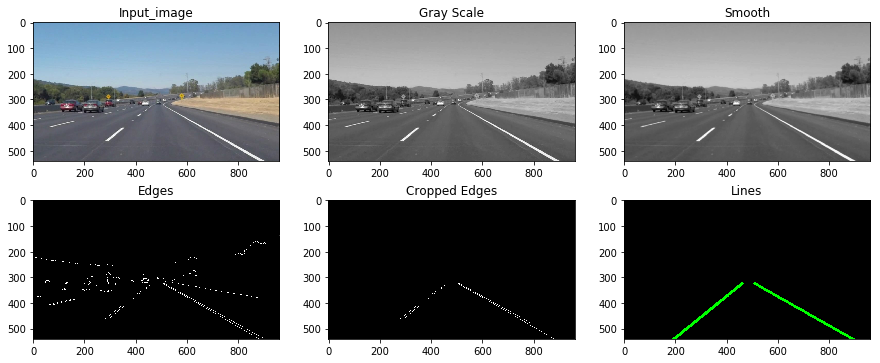

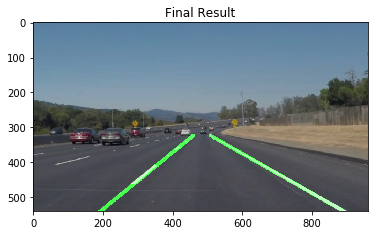

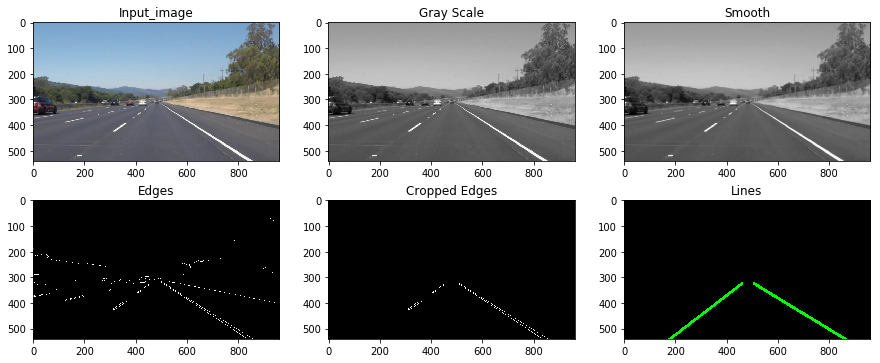

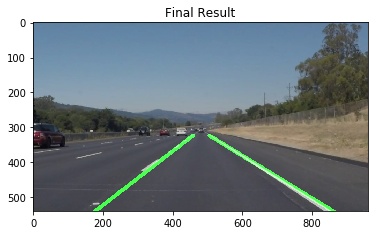

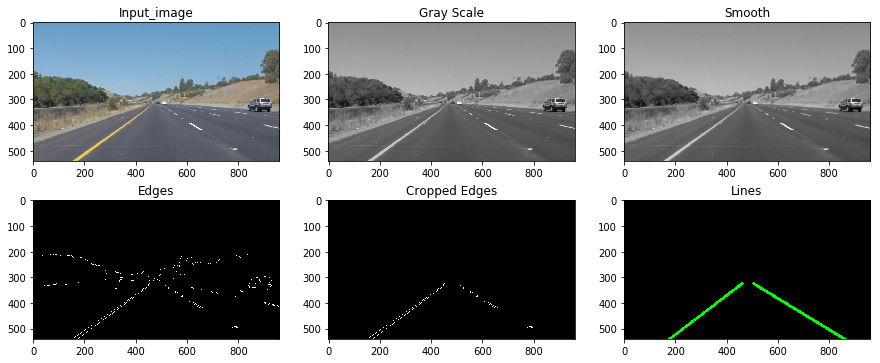

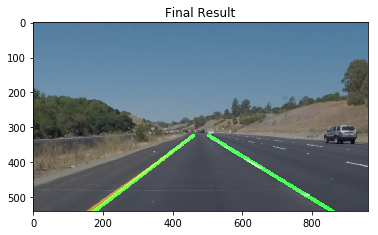

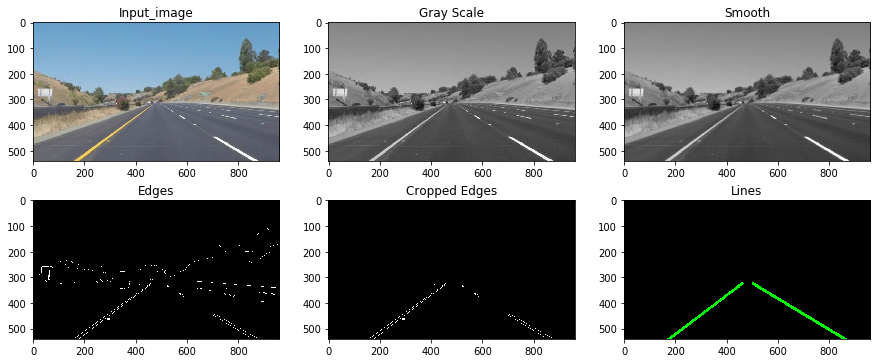

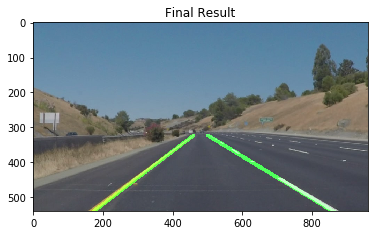

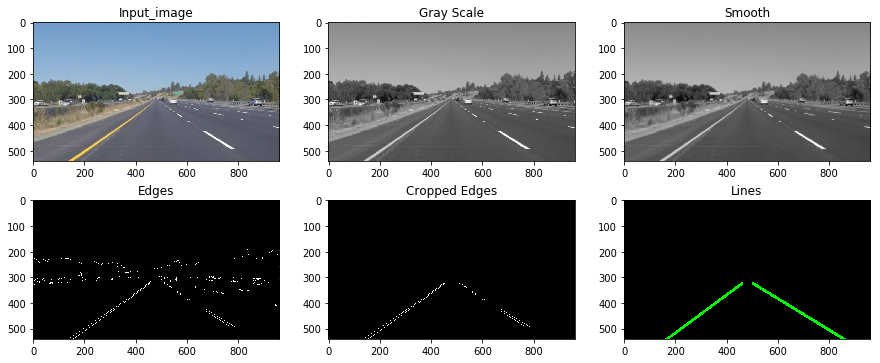

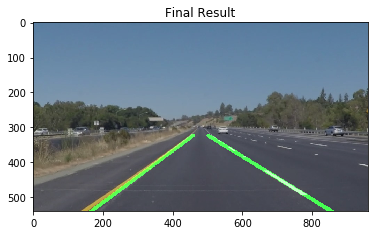

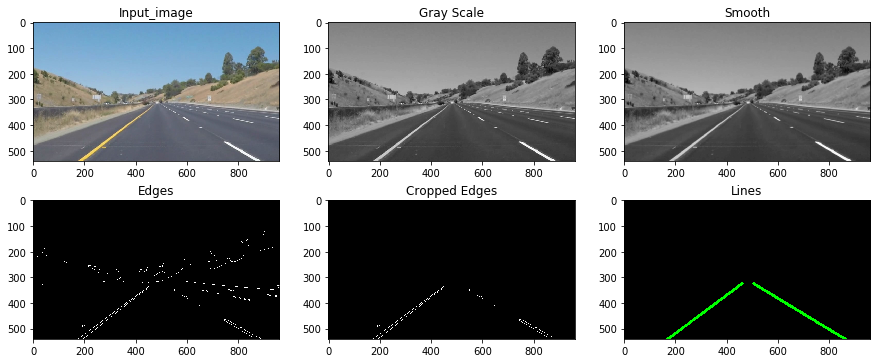

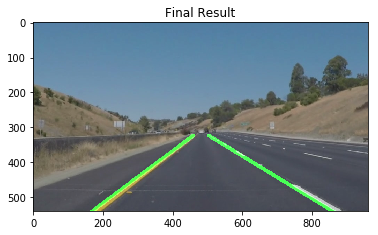

In [4]:
directory = "test_images/"
images_list  = os.listdir(directory)

kernel = 5 #Gaussian kernel size
low_threshold = 150 # threshold for canny edge detection
high_threshold = 200 
weights = np.array([[.43,.6],[.57,.6],[.92,1],[.08,1]]) #vertices fo the ROI in percentage
rho = 1 #Hough  parameters
theta = np.pi/180
threshold = 50
min_line_length = 40
max_line_gap = 80
output_directory = 'output/'
history = deque(maxlen=10) #lines History

for file in images_list:
    # loading images
    image_path = directory + file
    input_image = mpimg.imread(image_path)
    process_image(input_image,True,True)

## Running on Videos


### Solid White Right

In [5]:
history = deque(maxlen=10) #lines History
white_output = output_directory +'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/white.mp4
[MoviePy] Writing video output/white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 40.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/white.mp4 

Wall time: 7.65 s


### Solid Yellow Left

In [6]:
history = deque(maxlen=10) #lines History
yellow_output = output_directory + 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video output/yellow.mp4
[MoviePy] Writing video output/yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:18<00:00, 36.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/yellow.mp4 

Wall time: 19.4 s


### Optional Challenge Video 1

In [7]:
history = deque(maxlen=10) #lines History
challenge_output = output_directory + 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video output/extra.mp4
[MoviePy] Writing video output/extra.mp4


100%|████████████████████████████████████████| 251/251 [00:13<00:00, 20.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/extra.mp4 

Wall time: 14.5 s


### Optional Challenge Video 2
Video recorded in my local street. I'm driving.

In [8]:
history = deque(maxlen=10) #lines History
local_street_output = output_directory +'local_street.mp4'
clip2 = VideoFileClip('local_street.mp4')
local_street_clip = clip2.fl_image(process_image)
%time local_street_clip.write_videofile(local_street_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(local_street_output))

[MoviePy] >>>> Building video output/local_street.mp4
[MoviePy] Writing video output/local_street.mp4


100%|████████████████████████████████████████| 627/627 [00:17<00:00, 39.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/local_street.mp4 

Wall time: 18.1 s
